In [41]:
import os
import pickle
import sys

import gymnasium as gym
from gymnasium.wrappers import NormalizeObservation, NormalizeReward, RescaleAction
from torch.optim import Adam

sys.path.append(os.path.abspath(".."))

from rlib.algorithms.model_free.a2c import a2c
from rlib.algorithms.model_free.ppo import ppo
from rlib.algorithms.model_free.reinforce import reinforce
from rlib.common.evaluation import get_trajectory, validation
from rlib.common.policies import (
    DiscreteStochasticMlpPolicy,
    MlpCritic,
    StochasticMlpPolicy,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
discrete = True

In [42]:
env = gym.make("Pendulum-v1", render_mode="rgb_array")

min_action, max_action = -1, 1
env = RescaleAction(env, min_action, max_action)

discrete = False

In [43]:
obs_dim = env.observation_space.shape[0]

if discrete:
    action_dim = env.action_space.n
else:
    action_dim = env.action_space.shape[0]

print(obs_dim, action_dim)

3 1


### Reinforce

In [35]:
if discrete:
    policy = DiscreteStochasticMlpPolicy(obs_dim, action_dim)
else:
    policy = StochasticMlpPolicy(obs_dim, action_dim)

optimizer = Adam(policy.parameters(), lr=1e-3)

In [36]:
reinforce(env, policy, optimizer, total_timesteps=100_000)

torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])


KeyboardInterrupt: 

In [26]:
validation(env, policy, deterministic=True)

-1155.7180723675503

### A2C

In [37]:
if discrete:
    actor = DiscreteStochasticMlpPolicy(obs_dim, action_dim)
else:
    actor = StochasticMlpPolicy(obs_dim, action_dim)

critic = MlpCritic(obs_dim)

actor_optimizer = Adam(actor.parameters(), lr=3e-4)
critic_optimizer = Adam(critic.parameters(), lr=1e-4)

In [38]:
a2c(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=100_000)

torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])
torch.Size([1999, 1])


KeyboardInterrupt: 

In [79]:
validation(env, actor, deterministic=True)

36.2

### PPO

In [44]:
if discrete:
    actor = DiscreteStochasticMlpPolicy(obs_dim, action_dim)
else:
    actor = StochasticMlpPolicy(obs_dim, action_dim)

critic = MlpCritic(obs_dim)

actor_optimizer = Adam(actor.parameters(), lr=3e-4)
critic_optimizer = Adam(critic.parameters(), lr=3e-4)

In [45]:
ppo(env, actor, critic, actor_optimizer, critic_optimizer, total_timesteps=30_000)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [10]:
validation(env, actor, deterministic=True)

-11.578979812574406

MovieWriter imagemagick unavailable; using Pillow instead.


saving...


{'states': [array([0.3862416 , 1.4266382 , 0.17692734], dtype=float32),
  array([0.34003246, 1.4302872 , 0.2864614 ], dtype=float32),
  array([0.23862796, 1.4330773 , 0.4753552 ], dtype=float32),
  array([0.10520747, 1.4257239 , 0.58572257], dtype=float32),
  array([-0.08905859,  1.3921188 ,  0.803689  ], dtype=float32),
  array([-0.30531237,  1.3202944 ,  0.90883225], dtype=float32),
  array([-0.54235303,  1.1922886 ,  1.0507729 ], dtype=float32),
  array([-0.7781139,  0.9949062,  1.180393 ], dtype=float32),
  array([-0.99669313,  0.7005358 ,  1.3819923 ], dtype=float32),
  array([-1.1370034 ,  0.34924948,  1.419977  ], dtype=float32),
  array([-1.1816864 , -0.01851028,  1.3919792 ], dtype=float32),
  array([-1.1373404, -0.3643222,  1.3170457], dtype=float32),
  array([-1.0079231, -0.6965706,  1.3451412], dtype=float32),
  array([-0.8105636, -0.9765324,  1.2986019], dtype=float32),
  array([-0.56508225, -1.1932342 ,  1.2485583 ], dtype=float32),
  array([-0.29821622, -1.3397038 ,  1.1

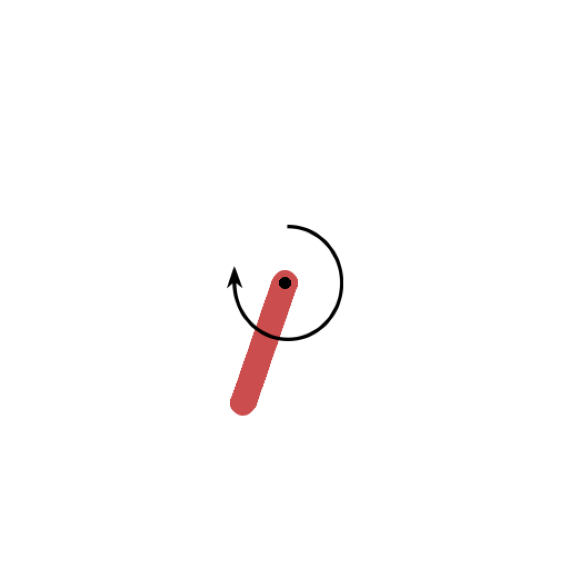

In [9]:
get_trajectory(env, actor, visualize=True)

In [85]:
# with open("./models/cartpole_stoc_expert", "wb") as file:
#     pickle.dump(actor, file)

### db

In [46]:
import torch

In [63]:
a = torch.tensor([1], requires_grad=True, dtype=torch.float32)
b = torch.tensor([2], requires_grad=True, dtype=torch.float32)
c = torch.tensor([3], requires_grad=True, dtype=torch.float32)

In [64]:
d = a * b + c

In [65]:
d.detach()

tensor([5.])

In [66]:
d.backward()

In [69]:
b.grad

tensor([1.])

In [164]:
actor.forward(torch.FloatTensor(env.observation_space.sample().reshape(1, -1)))

(tensor([[0.1195]], grad_fn=<TanhBackward0>),
 tensor([[0.0302]], grad_fn=<TanhBackward0>))

In [171]:
actor.predict(env.observation_space.sample())

(array([0.6580007], dtype=float32),
 tensor([[-1.1629]], grad_fn=<ViewBackward0>))

In [116]:
from rlib.common.buffer import RolloutBuffer

In [123]:
rb = RolloutBuffer()

In [124]:
rb.collect_rollouts(env, actor, rollout_size=500)

In [100]:
rb.collect_rollouts(env, policy, trajectories_n=1)

In [125]:
data = rb.get_data()

In [126]:
print(
    data["observations"].shape,
    data["actions"].shape,
    data["rewards"].shape,
    data["terminated"].shape,
    data["log_probs"][0].shape,
    data["q_estimations"].shape,
)

torch.Size([500, 3]) torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1]) torch.Size([500, 1])


In [128]:
loss = {}

returns = data["q_estimations"]
log_probs = data["log_probs"]

if True:
    mean = returns.mean()
    std = returns.std()
    returns = (returns - mean) / (std + 1e-8)

loss["actor"] = -(log_probs * returns).mean()

print(returns.shape, log_probs.shape, (log_probs * returns).shape)
print(loss["actor"].shape)

torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([])


In [129]:
import torch

In [132]:
loss = {}

observations = data["observations"]
log_probs = data["log_probs"]
targets = data["q_estimations"]

values = critic(observations)
advantages = targets[:-1].detach() - values[:-1]

loss["actor"] = -(log_probs[:-1] * advantages.detach()).mean()
loss["critic"] = (advantages**2).mean()

print(values.shape, advantages.shape, (log_probs[:-1] * advantages).shape)
print(loss["actor"].shape)

torch.Size([500, 1]) torch.Size([499, 1]) torch.Size([499, 1])
torch.Size([])


In [133]:
observations = data["observations"]
actions = data["actions"]
old_log_probs = data["log_probs"]
epsilon = 0.1

In [136]:
loss = {}

observations = data["observations"]
old_log_probs = data["log_probs"]
actions = data["actions"]
targets = data["q_estimations"]

_, new_log_probs = actor.get_action(observations, action=actions)

ratio = torch.exp(new_log_probs - old_log_probs.detach())
ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)

values = critic(observations)

advantages = targets.detach() - values

actor_loss_1 = ratio * advantages.detach()
actor_loss_2 = ratio_clipped * advantages.detach()

loss["actor"] = -(torch.min(actor_loss_1, actor_loss_2)).mean()
loss["critic"] = (advantages**2).mean()

print(ratio.shape, new_log_probs.shape, torch.min(actor_loss_1, actor_loss_2).shape)
print(loss["actor"].shape, loss["critic"].shape)

torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([]) torch.Size([])
